In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopy
from geopy import distance
from geopy.distance import vincenty
# from tqdm import tqdm
# tqdm.pandas()
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from scipy import stats
from dateutil import parser
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
import numpy as np

import eli5
from eli5.sklearn import PermutationImportance
# from skopt.space import Real
import matplotlib.colors as clt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Change pandas viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [24]:
train = pd.read_csv('listings.csv.gz', compression='gzip')
other_df = pd.read_csv('listings.csv')


In [25]:
# train.head()

In [26]:

lon = -90.0680352
lat = 29.9585246
train['distance_center'] = train.apply(lambda x: vincenty((x['latitude'], x['longitude']), (lat, lon)).miles, axis = 1)




In [27]:
train['price']=(train['price'].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))
train['cleaning_fee']=(train['cleaning_fee'].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))
train['security_deposit']=(train['security_deposit'].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))
sample = train.sample(1000, random_state=42)
bins= [0,50,100,150,200,250,300,350,400,450,500,10000]
labels = ['$50','$100','$150','$200','$250','$300','$350','$400','$450','$500', '$10000']
# sample['price'] = pd.cut(sample['price'], bins=bins, labels=labels)
train['price'].head()


0    300.0
1    100.0
2    125.0
3    115.0
4     50.0
Name: price, dtype: float64

In [28]:
train.head()
cleanmean=train['cleaning_fee'].dropna().mean()
train['cleaning_fee']=train['cleaning_fee'].fillna(cleanmean)
train['square_feet']=train['square_feet'].fillna(train['square_feet'].dropna().mean())
train['price']=train['price'].fillna(train['price'].dropna().mean())
train['bathrooms']=train['bathrooms'].fillna(train['bathrooms'].dropna().mean())
train['bedrooms']=train['bedrooms'].fillna(train['bedrooms'].dropna().mean())
train['beds']=train['beds'].fillna(train['beds'].dropna().mean())
train['square_feet']=train['square_feet'].fillna(train['square_feet'].dropna().mean())
train['security_deposit']=train['security_deposit'].fillna(train['security_deposit'].dropna().mean())
train['minimum_nights']=train['minimum_nights'].fillna(train['minimum_nights'].dropna().mean())

train['reviews_per_month']=train['reviews_per_month'].fillna(train['reviews_per_month'].dropna().mean())

In [29]:
train['price'].max()

8000.0

In [30]:
df = train.drop(columns=['listing_url','last_scraped','thumbnail_url', 'medium_url','picture_url','xl_picture_url','host_url','host_thumbnail_url','host_picture_url', 'neighbourhood','neighbourhood_group_cleansed','summary', 'neighborhood_overview','scrape_id','host_name','name', 'id', 'host_id', 'latitude', 'longitude', 'last_review'])
label_encoder=LabelEncoder()
label_encoder.fit(df['neighbourhood_cleansed'])
df['neighbourhood_cleansed']=label_encoder.transform(df['neighbourhood_cleansed'])
label_encoder.fit(df['minimum_nights'])
df['minimum_nights']=label_encoder.transform(df['minimum_nights'])

label_encoder.fit(df['square_feet'])
df['square_feet']=label_encoder.transform(df['square_feet'])
label_encoder.fit(df['property_type'])
df['property_type']=label_encoder.transform(df['property_type'])
label_encoder.fit(df['room_type'])
df['room_type']=label_encoder.transform(df['room_type'])
label_encoder.fit(df['distance_center'])
df['distance_center']=label_encoder.transform(df['distance_center'])
label_encoder.fit(df['cleaning_fee'])
df['cleaning_fee']=label_encoder.transform(df['cleaning_fee'])
label_encoder.fit(df['bathrooms'])
df['bathrooms']=label_encoder.transform(df['bathrooms'])
label_encoder.fit(df['bedrooms'])
df['bedrooms']=label_encoder.transform(df['bedrooms'])
label_encoder.fit(df['beds'])
df['beds']=label_encoder.transform(df['beds'])
label_encoder.fit(df['host_listings_count'])
df['host_listings_count']=label_encoder.transform(df['host_listings_count'])
label_encoder.fit(df['security_deposit'])
df['security_deposit']=label_encoder.transform(df['security_deposit'])
label_encoder.fit(df['guests_included'])
df['guests_included']=label_encoder.transform(df['guests_included'])
label_encoder.fit(df['number_of_reviews'])
df['number_of_reviews']=label_encoder.transform(df['number_of_reviews'])
label_encoder.fit(df['reviews_per_month'])
df['reviews_per_month']=label_encoder.transform(df['reviews_per_month'])

In [31]:

df['reviews_per_month'].max()

711

In [32]:

# bins1 = [48,100, 150, 250,300,350]
# labels1 = [1,2,3,4, 5]
# # train1['Price'] = pd.cut(train1['Price'], bins=bins1, labels=labels1).astype('int')
# df['Price'] = pd.cut(train1['Price'], bins=bins1, labels=labels1)

In [33]:
test = pd.DataFrame({
    'MinNights':df['minimum_nights'],
    'Hood': df['neighbourhood_cleansed'],
    'SqFt':df['square_feet'],
    '#Reviews':df['number_of_reviews'],
    '#Guests':df['guests_included'],
    'Listing Count':df['host_listings_count'],
    'Security':df['security_deposit'],
    'CleanFee':df['cleaning_fee'],
    'Dist':df['distance_center'],
#     'Room':df['room_type'],
    'BA':df['bathrooms'], 
#     'Prop':df['property_type'],
    'BR':df['bedrooms'], 
    'Beds': df['beds'],
    'Acc':df['accommodates'],
    'Price':df['price'],
    '#Booked':df['reviews_per_month']
})

# train1 = train.dropna()
test.to_csv('test1_data.csv')
# train1['Hood'].unique

In [34]:
df1 = df.groupby(['neighbourhood_cleansed']).mean()
price_grouped = other_df.groupby(['neighbourhood']).mean()
price = price_grouped['price']
# df.head()
df1.head()

,host_acceptance_rate,host_listings_count,host_total_listings_count,property_type,room_type,accommodates,bathrooms,bedrooms,beds,square_feet,price,security_deposit,cleaning_fee,guests_included,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,distance_center
neighbourhood_cleansed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,2.622951,7.606557,12.803279,0.114754,4.262295,2.213115,2.540984,3.065574,19.950820,140.786885,15.163934,55.245902,1.540984,1.147541,612.426230,2.016393,2.409836,612.426230,612.426230,2.178689,612.426230,6.540984,17.836066,35.147541,173.114754,50.180328,23.426230,97.754386,9.877193,9.842105,9.982456,9.912281,9.824561,9.859649,2.491803,2.344262,0.147541,0.0,237.049180,2149.278689
1,NaN,2.540984,5.032787,13.286885,0.180328,4.770492,2.663934,2.598361,3.147541,19.868852,240.122951,18.319672,60.778689,1.786885,1.631148,610.745902,3.713115,4.040984,610.745902,610.745902,3.770492,610.745902,9.524590,22.803279,41.663934,155.598361,37.631148,17.918033,97.214286,9.883929,9.758929,9.982143,9.964286,9.919643,9.732143,2.254098,1.836066,0.418033,0.0,184.942623,5931.852459
2,NaN,2.825758,5.128788,12.992424,0.098485,4.280303,2.090909,2.348485,2.742424,20.068182,182.477273,16.916667,53.143939,1.151515,1.553030,666.537879,2.893939,3.681818,637.446970,655.022727,3.228030,637.772727,7.446970,18.204545,36.886364,139.772727,36.719697,14.628788,97.904000,9.928000,9.856000,9.976000,9.984000,9.736000,9.864000,2.621212,2.416667,0.204545,0.0,170.015152,2986.962121
3,NaN,1.166667,1.166667,19.750000,0.083333,4.666667,2.166667,2.833333,2.916667,20.000000,122.750000,9.250000,52.750000,1.166667,0.916667,541.166667,1.916667,2.083333,541.166667,541.166667,1.975000,541.166667,9.916667,28.333333,52.583333,185.583333,15.166667,10.000000,94.888889,9.666667,9.555556,10.000000,10.000000,9.555556,9.777778,1.166667,1.083333,0.083333,0.0,191.416667,5211.416667
4,NaN,3.655172,14.137931,14.448276,0.275862,3.655172,1.793103,2.241379,2.344828,20.000000,147.862069,13.793103,50.103448,1.206897,1.965517,571.413793,4.034483,4.275862,571.413793,571.413793,4.086207,571.413793,6.862069,17.344828,32.586207,145.551724,45.724138,18.413793,96.923077,9.923077,9.769231,10.000000,9.884615,9.846154,9.730769,3.206897,2.827586,0.379310,0.0,204.310345,6301.448276


In [35]:
df1['price'].head()
# price.head()

neighbourhood_cleansed
0    140.786885
1    240.122951
2    182.477273
3    122.750000
4    147.862069
Name: price, dtype: float64

In [36]:
price_high = df1.loc[(df1['price']>=225)]
price_mid = df1[(df1['price']>150) & (df1['price'] <225)]
price_low = df1[(df1['price']>=0) & (df1['price'] <150)]
price_all = df1[df1['price']>1]
p_low = price_low.reset_index()
p_mid = price_mid.reset_index()
p_high = price_high.reset_index()
p_all = price_all.reset_index()

In [37]:
def bar_price(feature, index):
    fig, ax = plt.subplots()
    x_axis = np.arange(len(feature['price']))
    ax.bar(x_axis, feature['price'])
    labels =index['neighbourhood_cleansed']
    ax.set_xticks(x_axis)
    ax.set_xticklabels(labels, rotation=90, ha="right")

In [38]:

# bar_price(price_all, p_all)
# bar_price(price_low, p_low)
# bar_price(price_mid, p_mid)
# bar_price(price_high, p_high)

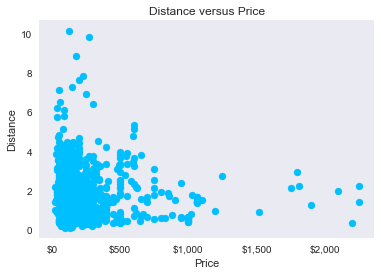

In [39]:
a = "#000080"
b = "#00BFFF"
c = "#32cd32"
d = "#FF4500"
clt.to_hex(a)
clt.to_hex(b)
clt.to_hex(c)
clt.to_hex(d)

price = sample['price']
dist = sample['distance_center']
fig, ax = plt.subplots()
ax.scatter(price,dist, color=b)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))


plt.style.use('seaborn')
plt.title('Distance versus Price')
plt.xlabel('Price')
plt.ylabel('Distance')
plt.grid()

plt.show()

In [40]:
# df = df.replace([np.inf, -np.inf], np.nan)
df = df.reset_index()
df.columns

Index(['index', 'space', 'description', 'experiences_offered', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
       'has_a

In [41]:
df['price'].min()

15.0

In [42]:

# df = df.drop(columns=['listing_url','last_scraped','thumbnail_url', 'medium_url','picture_url','xl_picture_url','host_url','host_thumbnail_url','host_picture_url', 'neighbourhood','neighbourhood_group_cleansed','summary', 'neighborhood_overview','scrape_id','host_name','name', 'id', 'host_id', 'latitude', 'longitude', 'last_review', 'reviews_per_month'])


train1 = pd.DataFrame({
    
        'MinNights':df['minimum_nights'],

    'Hood': df['neighbourhood_cleansed'],
    'SqFt':df['square_feet'],
    '#Reviews':df['number_of_reviews'],
    '#Guests':df['guests_included'],
    'Listing Count':df['host_listings_count'],
    'Security':df['security_deposit'],
    'CleanFee':df['cleaning_fee'],
    'Dist':df['distance_center'],
#     'Room':df['room_type'],
    'BA':df['bathrooms'], 
#     'Prop':df['property_type'],
    'BR':df['bedrooms'], 
    'Beds': df['beds'],
    'Acc':df['accommodates'],
    'Price':df['price'],
        '#Booked':df['reviews_per_month']

})
# train1=train1[:-1]
train.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,distance_center
0,10291,https://www.airbnb.com/rooms/10291,20190306190816,2019-03-06,Spacious Cottage in Mid-City!,NaN,"Spacious house located in Mid-City, New Orlean...","Spacious house located in Mid-City, New Orlean...",none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/99566384/f...,NaN,31004,https://www.airbnb.com/users/show/31004,Jill,2009-08-11,"New Orleans, Louisiana, United States",I'm from New Orleans and work in the insurance...,within an hour,100%,NaN,t,https://a0.muscache.com/im/users/31004/profile...,https://a0.muscache.com/im/users/31004/profile...,Navarre,1,1,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"New Orleans, LA, United States",Navarre,Navarre,NaN,New Orleans,LA,70124,New Orleans,"New Orleans, LA",US,United States,29.98666,-90.10928,t,Cottage,Entire home/apt,4,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",900.857143,300.0,NaN,NaN,0.00000,100.000000,4,$0.00,2,365,2,2,365,365,2.0,365.0,4 weeks ago,t,13,32,60,331,2019-03-06,96,14,2011-03-07,2019-02-17,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,17STR-04686,"{""Louisiana State"","" New Orleans"","" LA""}",f,f,moderate,t,f,1,1,0,0,0.99,3.142252
1,19091,https://www.airbnb.com/rooms/19091,20190306190816,2019-03-06,Fully Furnished Cozy Apartment,CITY OF NEW ORLEANS STR LICENSE PERMIT NUMBER:...,SEE SPECIAL REDUCED SUMMER PRICING! This apa...,CITY OF NEW ORLEANS STR LICENSE PERMIT NUMBER:...,none,"NorthWest Carrollton, where this apartment is ...",NaN,If you are going to use the trolley or bus sys...,Guests who stay for a week or longer will have...,The host is available for help with the apartm...,No smoking! No drugs. No pets. On street par...,NaN,NaN,https://a0.muscache.com/im/pictures/957168/75e...,NaN,72880,https://www.airbnb.com/users/show/72880,John,2010-01-23,"New Orleans, Louisiana, United States",I recently (2018) retired as the Director of B...,within an hour,100%,NaN,t,https://a0.muscache.com/im/users/72880/profile...,https://a0.muscache.com/im/users/72880/profile...,Riverbend,1,1,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"New Orleans, LA, United States",Uptown/Carrollton District,Leonidas,NaN,New Orleans,LA,70118,New Orleans,"New Orleans, LA",US,United States,29.96257,-90.11877

In [43]:
# bins=[0,25,50,100,150,200]
# labels=[1,2,3,4,5]
# # train1['CleanFee'] = pd.cut(train1['CleanFee'], bins=bins, labels=labels)
# train1['CleanFee'] = np.searchsorted(bins, train1['CleanFee'].values)

# bins2=[1000,2000,3000,4000,5000,6000]
# labels2=[.5,1,1.5,2,2.5,3]
# train1['Dist'] = np.searchsorted(bins2, train1['Dist'].values)

# # train1['Dist'] = pd.cut(train1['Dist'], bins=bins2, labels=labels2)

# bins1 = [50,100, 150, 250,300,400, 600, 1000, 8000]
# labels1 = [1,2,3,4, 5, 6,7, 8, 9]
# train1['Price'] = np.searchsorted(bins1, train1['Price'].values)
# # train1['Price'] = pd.cut(train1['Price'], bins=bins1, labels=labels1)
# bins3=[50,100,150,250,300,500]

# train1['#Reviews'] = np.searchsorted(bins3, train1['#Reviews'].values)
bins4 = [200, 300, 400,500, 600, 715]
# labels4 = [1,2,3,4, 5, 6,7, 8, 9]
train1['#Booked'] = np.searchsorted(bins4, train1['#Booked'].values)

# train1['Dist']=train1['Dist'].fillna(2)
# train1['CleanFee']=train1['CleanFee'].fillna(2)
# train1.to_csv('test_data.csv')
# # train1['Hood'].unique
# train1['#Booked']
train1.head()

,MinNights,Hood,SqFt,#Reviews,#Guests,Listing Count,Security,CleanFee,Dist,BA,BR,Beds,Acc,Price,#Booked
0,1,43,20,96,3,1,0,71,5591,4,4,4,4,300.0,0
1,0,33,15,288,1,1,0,40,5502,1,1,1,3,100.0,2
2,3,37,20,215,1,2,18,57,1630,1,1,1,2,125.0,1
3,2,54,20,133,1,2,0,49,3622,4,1,1,2,115.0,0
4,4,6,20,179,1,2,15,34,4571,1,1,1,2,50.0,0


In [44]:


from sklearn.preprocessing import StandardScaler

x = train1.drop('#Booked', axis=1)
y = train1['#Booked']
print(x.shape, y.shape)
y.dtypes

(6632, 14) (6632,)


dtype('int64')

In [45]:
# train1.groupby(['#Booked']).min()
train1['#Booked'].mean()


0.9597406513872135

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5, stratify=y)

x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.fit_transform(x_test)


# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)
# y_scaler = StandardScaler()
# encoded_y_train = (y_train)
# encoded_y_test = (y_test)


# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)
print(x_train_scaled.shape, y_train_categorical.shape)
print(x_test_scaled.shape, y_test_categorical.shape)


(3316, 14) (3316, 6)
(3316, 14) (3316, 6)


In [47]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)

In [48]:
clf = KNeighborsClassifier(n_neighbors =5)
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.47978815715350087


In [49]:
clf = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.5588064929400861


In [50]:
clf = RandomForestClassifier(n_estimators=21)
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.6355546620872632


In [51]:
clf = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.34499900052699484


In [52]:
# clf = SVC()
# scoring = 'accuracy'
# score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

# print(score.mean())

In [53]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, Conv2D, Activation, Reshape

# Create model and add layers
model = Sequential()
model.add(Dense(units=100, activation='relu',input_dim=x_train_scaled.shape[1]))
model.add(Dense(units=1000, activation='relu'))
model.add(Dense(units=100, activation='relu'))

model.add(Dense(units=100, activation='relu'))

model.add(Dense(units=y_train_categorical.shape[1], activation='softmax'))
# model.add(Flatten())
# model.add(Dense(units=2, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1500      
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              101000    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               100100    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 606       
Total params: 213,306
Trainable params: 213,306
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.compile(
#                 optimizer='adam',
                optimizer='adadelta',
#               loss='categorical_crossentropy',
              loss='mse',
#                  metrics=['mean_squared_error', 'mean_absolute_error'])
              metrics=['accuracy'])
# from keras.optimizers import SGD
# opt = SGD(lr=0.01)
# model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])


In [55]:
model.fit(
    x_train_scaled,
    y_train_categorical,
    epochs=25,
    batch_size=10,
    shuffle=True,
    verbose=2
)



Instructions for updating:
Use tf.cast instead.
Epoch 1/25
 - 2s - loss: 0.1054 - acc: 0.4937
Epoch 2/25
 - 2s - loss: 0.1012 - acc: 0.5211
Epoch 3/25
 - 1s - loss: 0.0992 - acc: 0.5377
Epoch 4/25
 - 2s - loss: 0.0979 - acc: 0.5419
Epoch 5/25
 - 1s - loss: 0.0963 - acc: 0.5425
Epoch 6/25
 - 1s - loss: 0.0953 - acc: 0.5540
Epoch 7/25
 - 2s - loss: 0.0942 - acc: 0.5543
Epoch 8/25
 - 2s - loss: 0.0933 - acc: 0.5621
Epoch 9/25
 - 2s - loss: 0.0926 - acc: 0.5672
Epoch 10/25
 - 2s - loss: 0.0912 - acc: 0.5706
Epoch 11/25
 - 2s - loss: 0.0897 - acc: 0.5838
Epoch 12/25
 - 1s - loss: 0.0886 - acc: 0.5911
Epoch 13/25
 - 1s - loss: 0.0876 - acc: 0.6016
Epoch 14/25
 - 1s - loss: 0.0864 - acc: 0.6055
Epoch 15/25
 - 1s - loss: 0.0847 - acc: 0.6134
Epoch 16/25
 - 1s - loss: 0.0834 - acc: 0.6200
Epoch 17/25
 - 1s - loss: 0.0822 - acc: 0.6339
Epoch 18/25
 - 1s - loss: 0.0806 - acc: 0.6387
Epoch 19/25
 - 1s - loss: 0.0796 - acc: 0.6429
Epoch 20/25
 - 1s - loss: 0.0780 - acc: 0.6496
Epoch 21/25
 - 1s - l

In [56]:

model.evaluate(x_test_scaled, y_test_categorical, verbose=2)

[0.11453371035750726, 0.5226176115083176]

In [57]:
model.evaluate(x_train_scaled, y_train_categorical, verbose=2)

[0.07281413626271796, 0.6927020507353494]

In [58]:
encoded_predictions = model.predict_classes(x_test_scaled[:5])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)
print(f"Predicted classes: {prediction_labels}")
print(f"Actual Labels: {list(y_test[:5])}")


Predicted classes: [3 0 0 0 1]
Actual Labels: [4, 0, 0, 1, 1]


In [59]:
model.save("airbnb.h5")

In [60]:
from keras.models import load_model
model1=load_model("airbnb.h5")
testing = pd.read_csv('test_data.csv')
testing.head()

,Unnamed: 0,MinNights,Hood,SqFt,#Reviews,#Guests,Listing Count,Security,CleanFee,Dist,BA,BR,Beds,Acc,Price,#Booked
0,0,1,43,20,1,3,1,0,3,5,4,4,4,4,4,0
1,1,0,33,15,4,1,1,0,2,5,1,1,1,3,1,2
2,2,3,37,20,3,1,2,18,3,1,1,1,1,2,2,1
3,3,2,54,20,2,1,2,0,2,3,4,1,1,2,2,0
4,4,4,6,20,3,1,2,15,2,4,1,1,1,2,0,0


In [61]:
test_data=testing.drop('Unnamed: 0', axis=1)
price=test_data['#Booked']
test_data=test_data.drop('#Booked', axis=1)

x_scaler=StandardScaler().fit(test_data)
x_test_scaled1 = x_scaler.transform(test_data)
prediction=model1.predict_classes(x_test_scaled1)

label_encoder = LabelEncoder()
label_encoder.fit(price)
y_test1 = label_encoder.fit_transform(price)
encoded_predictions1 = model1.predict_classes(x_test_scaled1[:6])
prediction_labels1 = label_encoder.inverse_transform(encoded_predictions1)
print(f"Predicted classes: {prediction_labels1}")
print(f"Actual Labels: {list(y_test1[:6])}")


Predicted classes: [0 3 1 0 2 3]
Actual Labels: [0, 2, 1, 0, 0, 0]


In [62]:
# test_data.head()
submission = pd.DataFrame({"Prediction":prediction_labels1[:6], "Booked":y_test1[:6]})
submission.head(6)

,Prediction,Booked
0,0,0
1,3,2
2,1,1
3,0,0
4,2,0
5,3,0


In [63]:
regr = GradientBoostingRegressor(n_estimators=75, learning_rate=0.17, max_depth=5, subsample=1.0,
                                 random_state=42)
regr.fit(x_train, y_train)
print(r2_score(y_test, regr.predict(x_test)))

0.42363043979806536


In [64]:
perm = PermutationImportance(regr, random_state=42).fit(x_test, y_test)
eli5.show_weights(perm, top=x.shape[1], feature_names = x.columns.tolist())

Weight,Feature
0.5777 ± 0.0353,#Reviews
0.1109 ± 0.0175,Price
0.0952 ± 0.0161,MinNights
0.0537 ± 0.0132,CleanFee
0.0409 ± 0.0060,Dist
0.0383 ± 0.0046,Acc
0.0280 ± 0.0044,Listing Count
0.0203 ± 0.0059,Security
0.0165 ± 0.0067,#Guests
0.0102 ± 0.0049,Hood


In [65]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [66]:
print(f"Training Data Score: {classifier.score(x_train, y_train)}")
print(f"Testing Data Score: {classifier.score(x_test, y_test)}")

Training Data Score: 0.5186972255729795
Testing Data Score: 0.5208082026537998


In [67]:
clf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(clf, x_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())


0.6251501474174644


In [68]:
clf.fit(x_train,y_train)
import os
from sklearn.tree import export_graphviz
import six
import pydot
from sklearn import tree
dotfile = six.StringIO()
i_tree = 0
for tree_in_forest in clf.estimators_:
    export_graphviz(tree_in_forest,out_file='tree.dot',
    feature_names=x_train.columns,
    filled=True,
    rounded=True)
    (graph,) = pydot.graph_from_dot_file('tree.dot')
    name = 'tree' + str(i_tree)
    graph.write_png(name+  '.png')
    os.system('dot -Tpng tree.dot -o tree.png')
    i_tree +=1

In [69]:
clf.fit(x_train,y_train)
prediction=clf.predict(test_data)
submission = pd.DataFrame({"Prediction":prediction, "Booked":price})
submission.to_csv('submission')
submission.head(5)


,Prediction,Booked
0,1,0
1,4,2
2,0,1
3,0,0
4,0,0


In [70]:
# Create model and add layers

model1 = Sequential()
model1.add(Dense(units=100, activation='tanh',input_dim=x_train_scaled.shape[1]))
  
model1.add(Dense(units=1000, activation='softmax'))
model1.add(Dense(units=100, activation='relu'))

# model1.add(Dense(units=100, activation='sigmoid'))

model1.add(Dense(units=6, activation='softmax'))
# model.add(Flatten())
# model.add(Dense(units=2, activation='softmax'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               1500      
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              101000    
_________________________________________________________________
dense_8 (Dense)              (None, 100)               100100    
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 606       
Total params: 203,206
Trainable params: 203,206
Non-trainable params: 0
_________________________________________________________________


In [71]:
model1.compile(
                optimizer='adam',
#                 optimizer='adadelta',
              loss='categorical_crossentropy',
#               loss='mse',
#                  metrics=['mean_squared_error', 'mean_absolute_error'])
              metrics=['accuracy'])

In [72]:
model1.fit(
   x_train_scaled,
    y_train_categorical,
    epochs=5,
    batch_size=10,
    shuffle=True,
    verbose=2
)


Epoch 1/5
 - 2s - loss: 1.3370 - acc: 0.4943
Epoch 2/5
 - 1s - loss: 1.1652 - acc: 0.5226
Epoch 3/5
 - 1s - loss: 1.1455 - acc: 0.5265
Epoch 4/5
 - 1s - loss: 1.1311 - acc: 0.5265
Epoch 5/5
 - 1s - loss: 1.1222 - acc: 0.5302


In [73]:
model1.evaluate(x_test_scaled, y_test_categorical, verbose=2)


[1.12887493174959, 0.5337756333650236]

In [74]:
model1.evaluate(x_train_scaled, y_train_categorical, verbose=2)

[1.101873246119307, 0.5382991554653688]

In [75]:

model.save("airbnb1.h5")


In [76]:
from keras.models import load_model
model1=load_model("airbnb1.h5")
testing = pd.read_csv('test_data.csv')
testing.head()
test_data=testing.drop('Unnamed: 0', axis=1)
price=test_data['#Booked']
test_data=test_data.drop('#Booked', axis=1)

x_scaler=StandardScaler().fit(test_data)
x_test_scaled = x_scaler.transform(test_data)
prediction=model1.predict_classes(x_test_scaled)

label_encoder = LabelEncoder()
label_encoder.fit(price)
y_test = label_encoder.fit_transform(price)
encoded_predictions = model1.predict_classes(x_test_scaled[:6])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)
print(f"Predicted classes: {prediction_labels}")
print(f"Actual Labels: {list(y_test[:6])}")
submission = pd.DataFrame({"Prediction":prediction_labels[:6], "Price":y_test[:6]})
submission.head(6)

Predicted classes: [0 3 1 0 2 3]
Actual Labels: [0, 2, 1, 0, 0, 0]


,Prediction,Price
0,0,0
1,3,2
2,1,1
3,0,0
4,2,0
5,3,0


In [79]:
from sklearn.tree import export_graphviz
# from IPython import display
from sklearn.ensemble import RandomForestRegressor


(str_tree)

NameError: name 'str_tree' is not defined